<a href="https://colab.research.google.com/github/Aditya-Shandilya1182/extreme_classification/blob/main/PGELU_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
import numpy as np

In [2]:
import math

In [3]:
class ParameterizedGeLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='GlorotNormal', beta_initializer='GlorotNormal', **kwargs):
        super(ParameterizedGeLU, self).__init__(**kwargs)
        self.alpha_initializer = initializers.get(alpha_initializer)
        self.beta_initializer = initializers.get(beta_initializer)
        self.alpha_values = []
        self.beta_values = []

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(1,), initializer=self.alpha_initializer, name='alpha')
        self.beta = self.add_weight(shape=(1,), initializer=self.beta_initializer, name='beta')
        super(ParameterizedGeLU, self).build(input_shape)

    def call(self, inputs, training = None):
        alpha = self.alpha
        beta = self.beta
        const = math.sqrt(2 / math.pi)
        if training:
            self.alpha_values.append(alpha)
            self.beta_values.append(beta)
        return self.beta * 0.5 * inputs * (1 + tf.tanh(const * (self.alpha * inputs + 0.044715 * tf.pow(inputs, 3))))

    def get_config(self):
        config = super(ParameterizedGeLU, self).get_config()
        config.update({
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'beta_initializer': initializers.serialize(self.beta_initializer)
        })
        return config

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

class ImageClassificationModel:
    def __init__(self):
        self.model = models.Sequential()

    def build_model(self):
        inputs = Input(shape=(32, 32, 3))
        ffnn_output = Conv2D(32, (3, 3))(inputs)
        gelu_layer = ParameterizedGeLU()(ffnn_output)
        pooling = MaxPooling2D((2, 2))(gelu_layer)
        ffnn_output = Conv2D(64, (3, 3))(pooling)
        gelu_layer = ParameterizedGeLU()(ffnn_output)
        pooling = MaxPooling2D(2, 2)(gelu_layer)
        ffnn_output = Conv2D(64, (3, 3))(pooling)
        gelu_layer = ParameterizedGeLU()(ffnn_output)
        ffnn_output = Flatten()(gelu_layer)
        ffnn_output = Dense(64)(ffnn_output)
        gelu_layer = ParameterizedGeLU()(ffnn_output)
        outputs = Dense(10)(gelu_layer)

        model = Model(inputs=inputs, outputs=outputs)
        return model

# Compile the model
image_classifier = ImageClassificationModel()
model = image_classifier.build_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 parameterized_ge_lu_8 (Par  (None, 30, 30, 32)        2         
 ameterizedGeLU)                                                 
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 parameterized_ge_lu_9 (Par  (None, 13, 13, 64)        2     

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [5]:
(train_images, train_labels), (test_images, test_labels) =  tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0


170498071/170498071 [==============================] - 3s 0us/step


In [11]:
class SaveAlphaBetaValues(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.alpha_beta_values = []

    def on_epoch_end(self, epoch, logs=None):
        epoch_values = {'epoch': epoch + 1, 'layers': []}
        for i, layer in enumerate(self.model.layers):
            if isinstance(layer, ParameterizedGeLU):
                alpha_values = layer.alpha.numpy()
                beta_values = layer.beta.numpy()
                epoch_values['layers'].append({'layer': i + 1, 'alpha': alpha_values, 'beta': beta_values})
        self.alpha_beta_values.append(epoch_values)

    def get_alpha_beta_values(self):
        return self.alpha_beta_values


In [20]:
callback = SaveAlphaBetaValues(model)
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=[callback])


Epoch 1/10
1563/1563 [==============================] - 14s 7ms/step - loss: 1.5608 - accuracy: 0.4381 - val_loss: 1.2799 - val_accuracy: 0.5452
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1415 - accuracy: 0.5949 - val_loss: 1.0670 - val_accuracy: 0.6297
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9596 - accuracy: 0.6621 - val_loss: 1.0038 - val_accuracy: 0.6546
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8339 - accuracy: 0.7051 - val_loss: 0.9263 - val_accuracy: 0.6805
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7405 - accuracy: 0.7387 - val_loss: 0.9468 - val_accuracy: 0.6777
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6564 - accuracy: 0.7660 - val_loss: 0.9338 - val_accuracy: 0.6837
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5791 - accuracy: 0.7941 - val_loss: 0.9892 - val_acc

In [21]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 1.1816 - accuracy: 0.6825 - 826ms/epoch - 3ms/step

Test accuracy: 0.6825000047683716


In [22]:
alpha_beta_values = callback.get_alpha_beta_values()
alpha_beta_values

[{'epoch': 1,
  'layers': [{'layer': 3,
    'alpha': array([1.3339602], dtype=float32),
    'beta': array([-2.0547438], dtype=float32)},
   {'layer': 6,
    'alpha': array([0.8561619], dtype=float32),
    'beta': array([-0.22890621], dtype=float32)},
   {'layer': 9,
    'alpha': array([-1.8016884], dtype=float32),
    'beta': array([0.8158615], dtype=float32)},
   {'layer': 12,
    'alpha': array([0.7699924], dtype=float32),
    'beta': array([1.8185709], dtype=float32)}]},
 {'epoch': 2,
  'layers': [{'layer': 3,
    'alpha': array([1.3282342], dtype=float32),
    'beta': array([-2.0801356], dtype=float32)},
   {'layer': 6,
    'alpha': array([0.79228467], dtype=float32),
    'beta': array([-0.2857396], dtype=float32)},
   {'layer': 9,
    'alpha': array([-1.9035857], dtype=float32),
    'beta': array([0.8233774], dtype=float32)},
   {'layer': 12,
    'alpha': array([0.75859743], dtype=float32),
    'beta': array([1.8253291], dtype=float32)}]},
 {'epoch': 3,
  'layers': [{'layer': 3,
 

In [23]:
alpha_beta_array = []

for epoch_data in alpha_beta_values:
    epoch_array = []
    for layer_data in epoch_data['layers']:
        alpha_value = layer_data['alpha'][0]  # Extract the first element of the list
        beta_value = layer_data['beta'][0]    # Extract the first element of the list
        epoch_array.append([alpha_value, beta_value])
    alpha_beta_array.append(epoch_array)

alpha_beta_array = np.array(alpha_beta_array)

In [24]:
alpha_beta_array

array([[[ 1.3339602 , -2.0547438 ],
        [ 0.8561619 , -0.22890621],
        [-1.8016884 ,  0.8158615 ],
        [ 0.7699924 ,  1.8185709 ]],

       [[ 1.3282342 , -2.0801356 ],
        [ 0.79228467, -0.2857396 ],
        [-1.9035857 ,  0.8233774 ],
        [ 0.75859743,  1.8253291 ]],

       [[ 1.3119775 , -2.0682058 ],
        [ 0.7302256 , -0.31555378],
        [-1.9344214 ,  0.8460881 ],
        [ 0.74156946,  1.8484905 ]],

       [[ 1.2904267 , -2.0381858 ],
        [ 0.6794261 , -0.32290202],
        [-1.9586709 ,  0.8626304 ],
        [ 0.70448875,  1.8726357 ]],

       [[ 1.2719766 , -2.0205936 ],
        [ 0.64259917, -0.3284855 ],
        [-1.9700541 ,  0.88931006],
        [ 0.6625251 ,  1.9080247 ]],

       [[ 1.2521619 , -2.000152  ],
        [ 0.5982262 , -0.33254075],
        [-1.9896933 ,  0.919018  ],
        [ 0.60965484,  1.9456867 ]],

       [[ 1.238689  , -1.9848118 ],
        [ 0.57844603, -0.3294392 ],
        [-1.9807458 ,  0.95158666],
        [ 0.5399

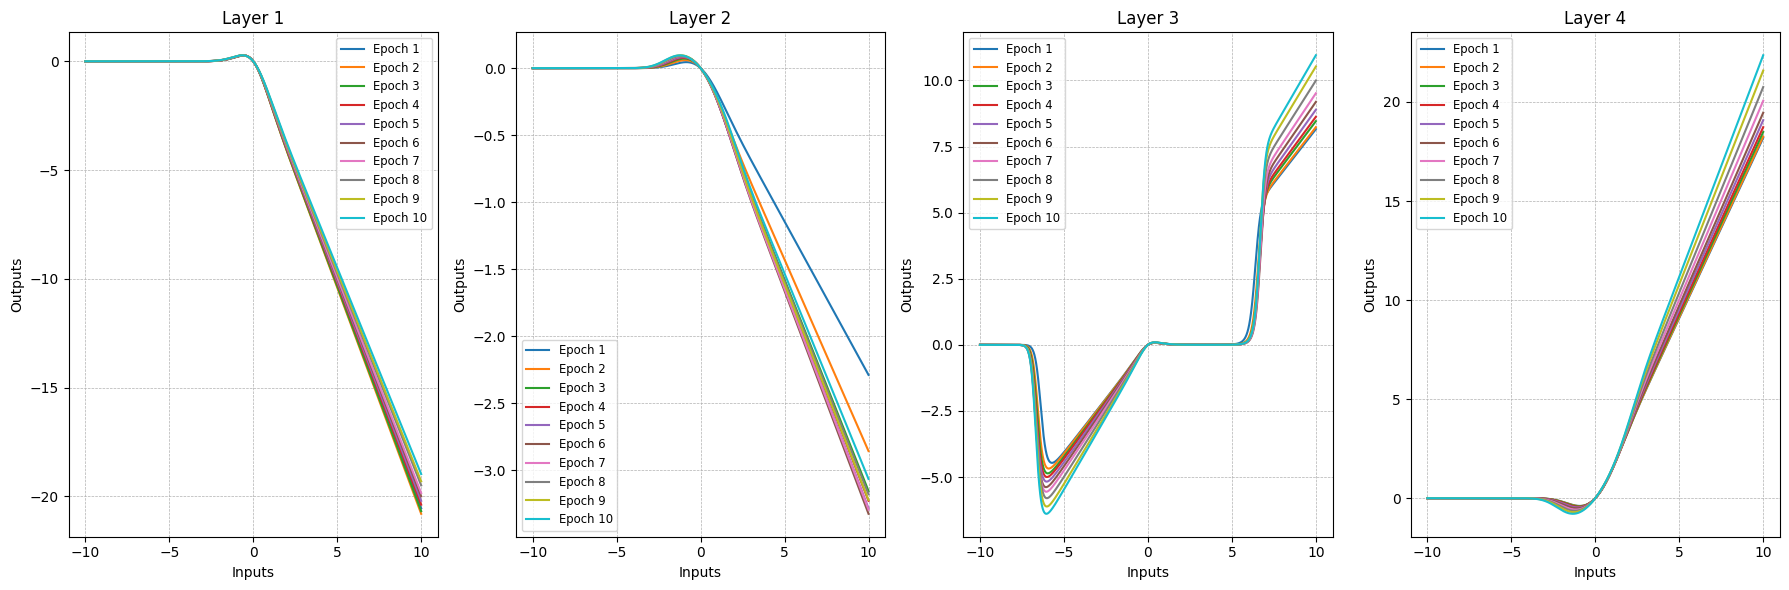

In [35]:
import matplotlib.pyplot as plt

inputs = np.linspace(-10, 10, 10000)  # 400 points between -2 and 2

# Plotting the results
plt.figure(figsize=(18, 6))

def parameterized_gelu(alpha, beta, inputs):
    const = math.sqrt(2 / math.pi)
    return beta * 0.5 * inputs * (1 + tf.tanh(const * (alpha * inputs + 0.044715 * tf.pow(inputs, 3))))

for layer_idx in range(alpha_beta_array.shape[1]):
    plt.subplot(1, alpha_beta_array.shape[1], layer_idx + 1)

    for epoch_idx in range(alpha_beta_array.shape[0]):
        alpha = alpha_beta_array[epoch_idx, layer_idx, 0]
        beta = alpha_beta_array[epoch_idx, layer_idx, 1]
        outputs = parameterized_gelu(alpha, beta, inputs)
        plt.plot(inputs, outputs, label=f'Epoch {epoch_idx + 1}')

    plt.title(f'Layer {layer_idx + 1}')
    plt.xlabel('Inputs')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.ylabel('Outputs')
    plt.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()